In [243]:
import nltk
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
import re
import random
from sklearn.linear_model import LogisticRegression

In [244]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/fatma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [245]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " ", string)
    string = re.sub(r"\'ve", " ", string)
    string = re.sub(r"n\'t", " ", string)
    string = re.sub(r"n\'s", " ", string)
    string = re.sub(r"\'re", " ", string)
    string = re.sub(r"\'d", " ", string)
    string = re.sub(r"\'ll", " ", string)
    string = re.sub(r",", " ", string)
    string = re.sub(r"!", " ", string)
    string = re.sub(r"\(", " ", string)
    string = re.sub(r"\)", " ", string)
    string = re.sub(r"\?", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\//?", " ", string)
    string = re.sub(r"\d+", " ", string)
    string = re.sub(r"\$", " ", string)
    string = re.sub(r"\#", " ", string)
    return string.strip().lower()

In [621]:
def remove_stop(str):
    stop = set(stopwords.words('english'))
    lst = str.split()
    lst = [i for i in lst if i not in stop]
    return ' '.join(lst)

def stem (str):
    lst = str.split()
    lst = [st.stem(x) for x in lst]
    return ' '.join(lst)

#def remove_unwanted_words(str):
##    unwanted_words = ["httpaddress", "usrid", "D", "dd", "rt", "amp", "am", "pm", '``',
#                      "''", "", "//", "\\", "\\'s", "\\?", "\?","http","httpaddresshttpaddresst", "cohttpaddressek", "sat", "sun", "mon",
#                     "tue", "wed", "thu", "fri", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
#    lst = str.split(" ")
#    lst = [i for i in lst if i not in unwanted_words]
#    return ' '.join(lst)


def remove_unwanted_words(str):
    unwanted_words = ["httpaddress", "usrid", "D", "dd", "rt", "amp", "am", "pm", '``',
                      "''", "", "//", "\\", "\\'s", "\\?", "\?","http","httpaddresshttpaddresst", "cohttpaddressek",
                      "taksim","gezi", "park", "direngeziparki", "occupygezi", "istanbul", "turkish","turkey",
                      "protest","direngezipark","direnankara","geziparki", "protesters", "protests", "sat", "sun", "mon,",
                     "tue", "wed", "thu", "fri", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
    lst = str.split(" ")
    lst = [i for i in lst if i not in unwanted_words]
    return ' '.join(lst)

def toLower(str):
    lst = str.split()
    lst = [i.lower() for i in lst]
    return ' '.join(lst)

def word_len (str):
    lst = str.split()
    lst = [i for i in lst if len(i)>1 and len(i) <7]
    return ' '.join(lst)

def sent_len (str):
    lst = str.split()
    if len(lst)>=3:
        return ' '.join(lst)

In [622]:
def clean_data(data):
    """
    Loads MR polarity african_data from files, splits the african_data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load african_data from files
    positive_examples = data
    positive_examples = positive_examples.strip() 
    positive_examples = remove_stop(positive_examples) 
    #print(positive_examples[0])
    positive_examples = toLower(positive_examples) 
    #rint(positive_examples[0])
    positive_examples = clean_str(positive_examples) 
    #rint(positive_examples[0])
    #positive_examples = [stem(item) for item in positive_examples]
    #rint(positive_examples[0])
    positive_examples = remove_unwanted_words(positive_examples)
    #positive_examples = word_len(positive_examples) 
    positive_examples = sent_len(positive_examples) 
    
    return positive_examples
    

In [765]:
df_cf_judgments = pd.read_csv('Data/CF_label_confidence_judgments_finalized_22_05_2018.csv')

In [766]:
df_cf_judgments.columns

Index(['Unnamed: 0', '_unit_id', '_golden', '_unit_state_x',
       '_trusted_judgments', '_last_judgment_at_x', 'violence_judgment',
       'violence', 'violence_confidence', 'protest_judgment_x', 'protest',
       'protest_confidence', 'created_at', 'id', 'proccd_text'],
      dtype='object')

In [767]:
len(df_cf_judgments)

1315

In [768]:
df_cf_judgments.columns

Index(['Unnamed: 0', '_unit_id', '_golden', '_unit_state_x',
       '_trusted_judgments', '_last_judgment_at_x', 'violence_judgment',
       'violence', 'violence_confidence', 'protest_judgment_x', 'protest',
       'protest_confidence', 'created_at', 'id', 'proccd_text'],
      dtype='object')

In [769]:
df_cf_judgments = df_cf_judgments[df_cf_judgments['_golden']==False]

In [770]:
len(df_cf_judgments)

1315

In [771]:
len(df_cf_judgments.drop_duplicates())

1315

In [772]:
df_cf_judgments['violence'] = df_cf_judgments['violence'].fillna(0)
df_cf_judgments['violence_confidence'] = df_cf_judgments['violence_confidence'].fillna(0)
df_cf_judgments['violence_judgment'] = df_cf_judgments['violence_judgment'].fillna(1)

In [773]:
len(df_cf_judgments.dropna())

1315

In [774]:
df_cf_judgments = df_cf_judgments[df_cf_judgments['violence']!=-1]

In [775]:
len(df_cf_judgments)

1315

In [776]:
df_cf_judgments['clean_text'] = df_cf_judgments['proccd_text'].apply(lambda x:clean_data(x) )

In [777]:
len(df_cf_judgments)

1315

In [778]:
df_cf_judgments['clean_text'] = df_cf_judgments['clean_text'].dropna()

In [779]:
df_cf_judgments = df_cf_judgments.drop_duplicates()

In [780]:
df_cf_judgments = df_cf_judgments[df_cf_judgments['clean_text']!=""]

In [781]:
df_cf_judgments['clean_text'].drop_duplicates()

0       lawn goose clothes lot outfit pattern sewing u...
1                       police blacked id numbers helmuts
2                                    occupy call akp govt
3       erdogan says vandals entering mosques beer bot...
4       photoset forest dreams needs support always me...
5       set barricades halt cops marching back sq hopi...
6                                                     NaN
7       moroccans protesting erdogan visit says crimin...
8             square designing common present future past
9                     investors baffled moneybeat wsj via
10         media ignoring ntv airing cooking show kidding
11                       police crush ankara photos video
12                    july turkeys human rights hypocrisy
13      borsa chapulled loses reached since chapullers...
14      police detaining protestors residents asked op...
15               guess everybody forgot london riots host
16                cbs riot police rush crush renewed news
17         wel

In [782]:
df_cf_judgments = df_cf_judgments[df_cf_judgments['clean_text']!=" "]

In [783]:
df_cf_judgments = df_cf_judgments[df_cf_judgments['clean_text'].isnull() == False]

In [784]:
len(df_cf_judgments)

1214

In [785]:
df_cf_judgments.to_csv('Data/CF_label_confidence_judgments_finalized_clean_text_22_05_2018.csv')

In [786]:
df_cf_judgments.columns

Index(['Unnamed: 0', '_unit_id', '_golden', '_unit_state_x',
       '_trusted_judgments', '_last_judgment_at_x', 'violence_judgment',
       'violence', 'violence_confidence', 'protest_judgment_x', 'protest',
       'protest_confidence', 'created_at', 'id', 'proccd_text', 'clean_text'],
      dtype='object')

In [787]:
test_predict_auc_all =[]
svm_labels = []

for i in range(1,10):
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_cf_judgments.clean_text, 
                                                    df_cf_judgments.violence, 
                                                    test_size=0.5)
    df_train_df = pd.concat([df_X_train,df_y_train],axis=1)
    df_test_df = pd.concat([df_X_test,df_y_test],axis = 1)
    print('training set size', len(df_train_df))
    print('training pos', len(df_train_df[df_train_df["violence"]==1]))
    print('training neg', len(df_train_df[df_train_df["violence"]==0]))
    print('test set size', len(df_test_df))
    print('test pos', len(df_test_df[df_test_df["violence"]==1]))
    print('test neg', len(df_test_df[df_test_df["violence"]==0]))
    
    df_pipeline_violence_Svc = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1, 2),stop_words='english',  min_df=3)),
    ('classifier',  SVC(kernel='linear', probability=True)) ])

    
    df_scores = cross_val_score(df_pipeline_violence_Svc, df_train_df.clean_text, df_train_df.violence, cv=10)
    print('scores',df_scores)
    print('scores mean',df_scores.mean())
    print('scores std',df_scores.std() * 2)
    
    df_cv_predict = cross_val_predict(df_pipeline_violence_Svc, df_train_df.clean_text, df_train_df.violence, cv=10)
    df_cv_predict_scores = metrics.roc_auc_score(df_train_df.violence, df_cv_predict)
    print('cv auc', df_cv_predict_scores)
    
    df_pipeline_violence_Svc_model = df_pipeline_violence_Svc.fit(df_train_df.clean_text, df_train_df.violence)
    df_prediction = df_pipeline_violence_Svc_model.predict(df_test_df.clean_text)
    df_predict_prob = df_pipeline_violence_Svc_model.predict_proba(df_test_df.clean_text)
    test_predict_auc = metrics.roc_auc_score(df_test_df.violence,df_prediction)
    print('test set auc', test_predict_auc)
    test_predict_auc_all.append(test_predict_auc)
    print(metrics.confusion_matrix(df_test_df.violence,df_prediction))

training set size 607
training pos 79
training neg 528
test set size 607
test pos 79
test neg 528
scores [0.85245902 0.8852459  0.83606557 0.86885246 0.86885246 0.93442623
 0.85245902 0.80327869 0.91666667 0.88135593]
scores mean 0.8699661943132352
scores std 0.07186427405072515
cv auc 0.6237893172228616
test set auc 0.6987917146144994
[[504  24]
 [ 44  35]]
training set size 607
training pos 76
training neg 531
test set size 607
test pos 82
test neg 525
scores [0.91935484 0.8852459  0.8852459  0.81967213 0.90163934 0.75409836
 0.96666667 0.9        0.91666667 0.85      ]
scores mean 0.8798589811387274
scores std 0.11263771084357424
cv auc 0.7057686589354742
test set auc 0.6678861788617886
[[490  35]
 [ 49  33]]
training set size 607
training pos 79
training neg 528
test set size 607
test pos 79
test neg 528
scores [0.8852459  0.85245902 0.95081967 0.85245902 0.90163934 0.85245902
 0.91803279 0.85245902 0.85       0.93220339]
scores mean 0.8847777160322311
scores std 0.0731810108160576

In [788]:
print('avg aucs on tests', np.mean(test_predict_auc_all))

avg aucs on tests 0.6728590557633948


In [764]:
#cv = CountVectorizer(ngram_range=(1, 2),stop_words='english',  min_df=3)
#cv = cv.fit(df_train_df.clean_text)
#svm = SVC(kernel='linear', probability=True)
#svm.fit(cv, df_train_df.violence)

#svm.support_vectors_

In [789]:
svm_test_results_df = pd.DataFrame({'clean_text':df_test_df.clean_text,'violence_prediction':df_prediction,
                                    'non_vio_prob':df_predict_prob[:,0],'vio_prob':df_predict_prob[:,1]})

In [790]:
len(svm_test_results_df)

607

In [791]:
len(svm_test_results_df.drop_duplicates())

607

In [792]:
svm_test_results_df = svm_test_results_df.drop_duplicates()

In [793]:
svm_test_results_df.to_csv('Data/svm_cf_task_results_22_05_2018.csv')

In [794]:
len(pd.read_csv('Data/svm_cf_task_results_22_05_2018.csv'))

607

In [795]:
svm_results_CF_judgment_merged = df_cf_judgments.merge(svm_test_results_df,
                                                      on='clean_text',
                                                      how='right')

In [796]:
svm_results_CF_judgment_merged.columns

Index(['Unnamed: 0', '_unit_id', '_golden', '_unit_state_x',
       '_trusted_judgments', '_last_judgment_at_x', 'violence_judgment',
       'violence', 'violence_confidence', 'protest_judgment_x', 'protest',
       'protest_confidence', 'created_at', 'id', 'proccd_text', 'clean_text',
       'non_vio_prob', 'vio_prob', 'violence_prediction'],
      dtype='object')

In [797]:
len(svm_results_CF_judgment_merged['_unit_id'].drop_duplicates())

610

In [798]:
len(svm_results_CF_judgment_merged.dropna())

610

In [799]:
len(svm_results_CF_judgment_merged.drop_duplicates())

610

In [800]:
svm_results_CF_judgment_merged.to_csv('Data/svm_results_CF_judgment_merged_22_05_2018.csv')

In [801]:
len(pd.read_csv('Data/svm_results_CF_judgment_merged_22_05_2018.csv'))

610

In [802]:
svm_results_CF_judgment_merged['violence_confidence'] = svm_results_CF_judgment_merged['violence_confidence'].fillna(0) 

In [803]:
violent_tweets = svm_results_CF_judgment_merged[svm_results_CF_judgment_merged['violence']==1]

print('avg CF user confidence on violent tweets',
      np.mean(violent_tweets['violence_confidence']))

avg CF user confidence on violent tweets 0.7389458823529412


In [804]:
print('avg CF user protest confidence on violent tweets',
      np.mean(violent_tweets['protest_confidence']))

avg CF user protest confidence on violent tweets 0.8969352941176472


Text(0.5,1,'the user confidence on violent tweets')

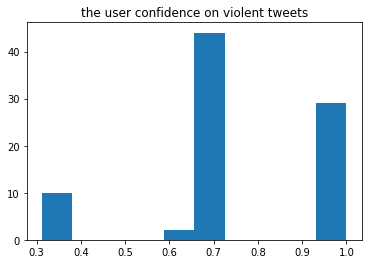

In [805]:
plt.hist(violent_tweets['violence_confidence'])
plt.title('the user confidence on violent tweets')

In [806]:
non_violent_tweets = svm_results_CF_judgment_merged[svm_results_CF_judgment_merged['violence']==0]

print('avg CF user confidence on non-violent tweets',
     np.mean(non_violent_tweets['violence_confidence']))

avg CF user confidence on non-violent tweets 0.3362940952380953


In [807]:
print('avg CF user protest confidence on violent tweets',
      np.mean(non_violent_tweets['protest_confidence']))

avg CF user protest confidence on violent tweets 0.9171401904761904


Text(0.5,1,'the user confidence on non-violent tweets')

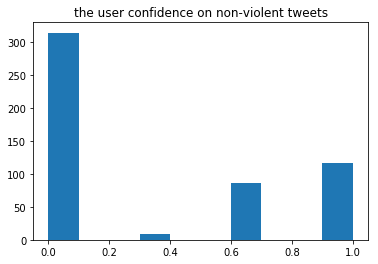

In [808]:
plt.hist(non_violent_tweets['violence_confidence'])
plt.title('the user confidence on non-violent tweets')

In [809]:
svm_results_CF_judgment_merged[svm_results_CF_judgment_merged['violence']==1]

,Unnamed: 0,_unit_id,_golden,_unit_state_x,_trusted_judgments,_last_judgment_at_x,violence_judgment,violence,violence_confidence,protest_judgment_x,protest,protest_confidence,created_at,id,proccd_text,clean_text,non_vio_prob,vio_prob,violence_prediction
9,16,1657977956,False,finalized,3,04/05/18 11:50,"""11""",1.0,0.6250,"""101""",1,0.6250,Sun Jun 16 11:41:34 +0000 2013,3.462310e+17,cbs riot police rush to crush renewed turkey p...,cbs riot police rush crush renewed news,0.940054,0.059946,0.0
23,49,1657977998,False,finalized,3,04/05/18 11:50,"""01""",1.0,0.3125,"""101""",1,0.6250,Sun Jun 16 19:34:30 +0000 2013,3.463500e+17,rt usrId #istanbul #protestors holding their g...,protestors holding ground despite organized at...,0.806367,0.193633,0.0
25,58,1657978009,False,finalized,3,3/30/2018 15:09:17,"""110""",1.0,0.6581,"""111""",1,1.0000,Sun Jun 16 10:41:39 +0000 2013,3.462160e+17,rt usrId police detaining the doctors at ramad...,police detaining doctors ramada hotel treating...,0.789181,0.210819,0.0
27,60,1657978012,False,finalized,3,3/30/2018 15:02:31,"""111""",1.0,1.0000,"""111""",1,1.0000,Wed Jun 12 18:49:45 +0000 2013,3.448890e+17,usrId riot police fire water cannon at protest...,riot police fire water cannon protester wheelc...,0.844936,0.155064,0.0
29,63,1657978015,False,finalized,3,3/30/2018 15:04:47,"""011""",1.0,0.6594,"""111""",1,1.0000,Mon Jun 03 17:58:30 +0000 2013,3.416150e+17,rt usrId police chopper circling over crowd of...,police chopper circling crowd tens thousands f...,0.963006,0.036994,0.0
45,94,1657978052,False,finalized,3,3/30/2018 15:29:27,"""10""",1.0,0.3388,"""011""",1,0.6748,Mon Jun 24 10:27:31 +0000 2013,3.491120e+17,rt usrId #simsek says some journalists killed ...,simsek says journalists killed people robbed m...,0.943174,0.056826,0.0
46,95,1657978053,False,finalized,3,3/30/2018 15:16:10,"""11""",1.0,0.6640,"""011""",1,0.6640,Sat Jun 01 18:57:26 +0000 2013,3.409050e+17,bbc news turkish protesters pack taksim square...,bbc news pack square police withdraw,0.545037,0.454963,1.0
47,96,1657978054,False,finalized,3,3/30/2018 15:24:33,"""11""",1.0,0.6594,"""011""",1,0.6594,Tue Jun 11 11:49:37 +0000 2013,3.444210e+17,turkish secret police agents provocateurs infi...,secret police agents provocateurs infiltrating...,0.792744,0.207256,0.0
87,206,1657978210,False,finalized,3,04/03/18 20:14,"""101""",1.0,0.6640,"""111""",1,1.0000,Sun Jun 02 23:08:29 +0000 2013,3.413310e+17,rt usrId 100s arrested in httpAddress protesto...,s arrested protestors locked basketball people...,0.979409,0.020591,0.0
88,213,1657978229,False,finalized,3,04/03/18 17:15,"""111""",1.0,1.0000,"""111""",1,1.0000,Thu Jun 13 17:59:50 +0000 2013,3.452390e+17,rt usrId fashionable to wear gas mask helmet g...,fashionable wear gas mask helmet goggles downt...,0.749047,0.250953,0.0


In [810]:
svm_results_CF_judgment_merged_righ_classification = svm_results_CF_judgment_merged[
                                                    svm_results_CF_judgment_merged['violence'] == svm_results_CF_judgment_merged['violence_prediction']
                                                    ]

In [811]:
svm_results_CF_judgment_merged_righ_classification.to_csv('Data/right_classififcation__svm_results_judgments_merge_23_05_2018.csv')

In [812]:
print('avg user confidence on the correctly classififed tweets is', 
      np.mean(svm_results_CF_judgment_merged_righ_classification.violence_confidence))

avg user confidence on the correctly classififed tweets is 0.3627936802973978


In [813]:
print('avg user protest confidence on the correctly classififed tweets is', 
      np.mean(svm_results_CF_judgment_merged_righ_classification.protest_confidence))

avg user protest confidence on the correctly classififed tweets is 0.9191243494423792


Text(0.5,1,'right classification CF workers confidence on violence')

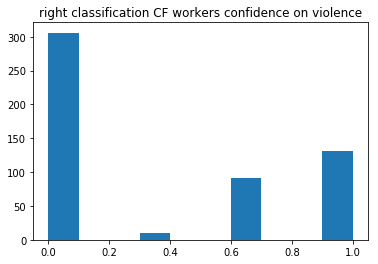

In [814]:
plt.hist(svm_results_CF_judgment_merged_righ_classification.violence_confidence)
plt.title('right classification CF workers confidence on violence')

In [815]:
svm_results_CF_judgment_merged_pos = svm_results_CF_judgment_merged_righ_classification[
    svm_results_CF_judgment_merged_righ_classification['violence'] == 1]

In [816]:
print('avg user protest confidence on the correctly classififed violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_pos.protest_confidence))

avg user protest confidence on the correctly classififed violent tweets is 0.9444833333333335


In [817]:
print('avg user confidence on the correctly classififed violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_pos.violence_confidence))

avg user confidence on the correctly classififed violent tweets is 0.8439166666666668


In [818]:
print('avg svm vio probability the correctly classififed violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_pos.vio_prob))

avg svm vio probability the correctly classififed violent tweets is 0.5660851140155775


In [819]:
print('avg svm nonviolence probability the correctly classififed violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_pos.non_vio_prob))

avg svm nonviolence probability the correctly classififed violent tweets is 0.43391488598442246


/Users/fatma/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


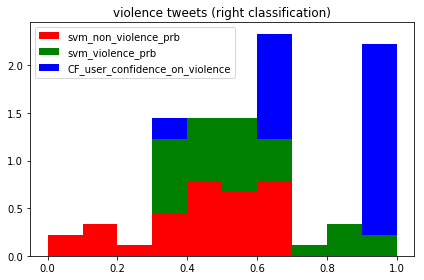

In [820]:
colors = ['red', 'green', 'blue']
labels = ['svm_non_violence_prb', 'svm_violence_prb', 'CF_user_confidence_on_violence']
plt.hist([svm_results_CF_judgment_merged_pos.non_vio_prob,
         svm_results_CF_judgment_merged_pos.vio_prob,
         svm_results_CF_judgment_merged_pos.violence_confidence],stacked=True,normed=1,
         histtype='bar',color=colors, label=labels )
plt.legend(prop={'size': 10})
plt.title('violence tweets (right classification)')
plt.tight_layout()
plt.show()

In [821]:
svm_results_CF_judgment_merged_neg = svm_results_CF_judgment_merged_righ_classification[
    svm_results_CF_judgment_merged_righ_classification['violence'] == 0]

In [822]:
print('avg user protest confidence on the correctly classififed non-violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_neg.protest_confidence))

avg user protest confidence on the correctly classififed non-violent tweets is 0.9176267716535433


In [823]:
print('avg user confidence on the correctly classififed non-violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_neg.violence_confidence))

avg user confidence on the correctly classififed non-violent tweets is 0.33438090551181104


In [824]:
print('svm avg proability (vio) correctly classififed non-violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_neg.vio_prob))

svm avg proability (vio) correctly classififed non-violent tweets is 0.06529027251293325


In [825]:
print('svm avg proability (non-vio) correctly classififed non-violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_neg.non_vio_prob))

svm avg proability (non-vio) correctly classififed non-violent tweets is 0.9347097274870667


/Users/fatma/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


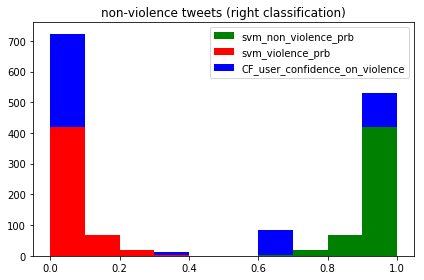

In [826]:
colors = ['green', 'red', 'blue']
labels = ['svm_non_violence_prb', 'svm_violence_prb', 'CF_user_confidence_on_violence']
plt.hist([svm_results_CF_judgment_merged_neg.non_vio_prob,
         svm_results_CF_judgment_merged_neg.vio_prob,
         svm_results_CF_judgment_merged_neg.violence_confidence],stacked=True,normed=0,
         histtype='bar',color=colors, label=labels )
plt.legend(prop={'size': 10})
plt.title('non-violence tweets (right classification)')
plt.tight_layout()
plt.show()

In [827]:
svm_results_CF_judgment_merged_mis_classification = svm_results_CF_judgment_merged[
                                                    svm_results_CF_judgment_merged['violence'] != svm_results_CF_judgment_merged['violence_prediction']
                                                    ]

In [828]:
print('avg user protest confidence on the mis-classififed tweets is', 
      np.mean(svm_results_CF_judgment_merged_mis_classification.protest_confidence))

avg user protest confidence on the mis-classififed tweets is 0.878461111111111


In [829]:
svm_results_CF_judgment_merged_mis_classification.to_csv('Data/misclassified_svm_results_judgments_merge_23_05_2018.csv')

In [830]:
print('avg user confidence on the mis-classififed tweets is', 
      np.mean(svm_results_CF_judgment_merged_mis_classification.violence_confidence))

avg user confidence on the mis-classififed tweets is 0.6136361111111112


Text(0.5,1,'CF user confidence on mis classified tweets')

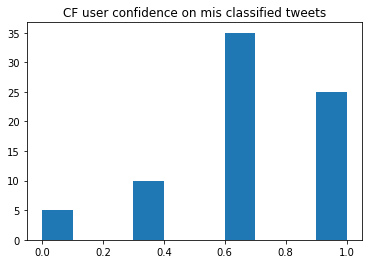

In [743]:
plt.hist(svm_results_CF_judgment_merged_mis_classification.violence_confidence)
plt.title('CF user confidence on mis classified tweets')

In [744]:
svm_results_CF_judgment_merged_misclassififcation_pos = svm_results_CF_judgment_merged_mis_classification[
    svm_results_CF_judgment_merged_mis_classification['violence'] == 1]

In [745]:
print('avg user protest confidence on the mis-classififed  violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_misclassififcation_pos.protest_confidence))

avg user protest confidence on the mis-classififed  violent tweets is 0.8965183673469387


In [746]:
print('avg user confidence on the mis-classififed  violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_misclassififcation_pos.violence_confidence))

avg user confidence on the mis-classififed  violent tweets is 0.7126265306122449


In [747]:
print('avg svm model probability (violent) mis-classififed  violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_misclassififcation_pos.vio_prob))

avg svm model probability (violent) mis-classififed  violent tweets is 0.13783761073757395


In [748]:
print('avg svm model probability (non violent) mis-classififed  violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_misclassififcation_pos.non_vio_prob))

avg svm model probability (non violent) mis-classififed  violent tweets is 0.862162389262426


In [749]:
svm_results_CF_judgment_merged_misclassififcation_neg = svm_results_CF_judgment_merged_mis_classification[
    svm_results_CF_judgment_merged_mis_classification['violence'] == 0]

In [750]:
svm_results_CF_judgment_merged_misclassififcation_neg['violence_prediction']

2      1.0
42     1.0
73     1.0
108    1.0
146    1.0
149    1.0
186    1.0
219    1.0
227    1.0
232    1.0
250    1.0
255    1.0
257    1.0
270    1.0
280    1.0
287    1.0
321    1.0
353    1.0
354    1.0
387    1.0
393    1.0
429    1.0
574    1.0
583    1.0
594    1.0
608    1.0
Name: violence_prediction, dtype: float64

In [751]:
print('avg user protest confidence on the mis-classififed  non-violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_misclassififcation_neg.protest_confidence))

avg user protest confidence on the mis-classififed  non-violent tweets is 0.8730000000000001


In [752]:
print('avg user confidence on the mis-classififed  non-violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_misclassififcation_neg.violence_confidence))

avg user confidence on the mis-classififed  non-violent tweets is 0.6412269230769231


In [753]:
print('avg svm model probability (violent) mis-classififed  non-violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_misclassififcation_neg.vio_prob))

avg svm model probability (violent) mis-classififed  non-violent tweets is 0.5828591385529177


In [754]:
print('avg svm model probability (non - violent) mis-classififed  non-violent tweets is', 
      np.mean(svm_results_CF_judgment_merged_misclassififcation_neg.non_vio_prob))

avg svm model probability (non - violent) mis-classififed  non-violent tweets is 0.4171408614470824


/Users/fatma/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


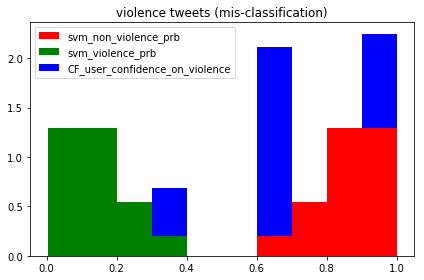

In [755]:
colors = ['red', 'green', 'blue']
labels = ['svm_non_violence_prb', 'svm_violence_prb', 'CF_user_confidence_on_violence']
plt.hist([svm_results_CF_judgment_merged_misclassififcation_pos.non_vio_prob,
         svm_results_CF_judgment_merged_misclassififcation_pos.vio_prob,
         svm_results_CF_judgment_merged_misclassififcation_pos.violence_confidence],stacked=True,normed=1,
         histtype='bar',color=colors, label=labels )
plt.legend(prop={'size': 10})
plt.title('violence tweets (mis-classification)')
plt.tight_layout()
plt.show()

/Users/fatma/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


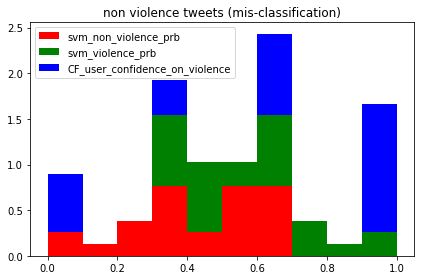

In [756]:
colors = ['red', 'green', 'blue']
labels = ['svm_non_violence_prb', 'svm_violence_prb', 'CF_user_confidence_on_violence']
plt.hist([svm_results_CF_judgment_merged_misclassififcation_neg.non_vio_prob,
         svm_results_CF_judgment_merged_misclassififcation_neg.vio_prob,
         svm_results_CF_judgment_merged_misclassififcation_neg.violence_confidence],stacked=True,normed=1,
         histtype='bar',color=colors, label=labels )
plt.legend(prop={'size': 10})
plt.title('non violence tweets (mis-classification)')
plt.tight_layout()
plt.show()